# Part 3: Peer-to-peer Message Behaviour Data Analysis

---

### Install Python packages (pip only)

In [17]:
#e.g., %pip install some-package
%pip install networkx
%pip install matplotlib
%pip install numpy
%pip install scipy
%pip install pandas
%pip install operator
%pip install ndlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement operator (from versions: none)
ERROR: No matching distribution found for operator


Note: you may need to restart the kernel to use updated packages.


### Import Python packages

In [18]:
#e.g., import some-package
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cs
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
%matplotlib inline 

---

### Task 1 of 2

Examine the file "p2p_msg_cmt224.csv" which represents messaging behaviour between users on a messaging platform. Each row has four columns, representing a single event where a person (person_a) messaged another person (person_b) on some date (date) at some time of day (time). From this, answer the following questions:

##### Q1. Build a suitable network to represent social connections based on the messaging behaviour that took place in the first 28 days. In doing so, assume that one or more messages from one person to another represents a mutual underlying social connection (i.e., regardless of whether person_a messaged person_b, person_b messaged person_a, or both at some point). 

    person_a  person_b        date      time            datetime
0         29        25  21/04/2004  00:34:43 2004-04-21 00:34:43
1         30        31  21/04/2004  04:18:26 2004-04-21 04:18:26
2         30        31  21/04/2004  04:18:31 2004-04-21 04:18:31
3         30        31  21/04/2004  04:18:33 2004-04-21 04:18:33
4         30        31  21/04/2004  04:18:36 2004-04-21 04:18:36
5         32        33  21/04/2004  04:27:03 2004-04-21 04:27:03
6         34        35  21/04/2004  06:32:10 2004-04-21 06:32:10
7         34        33  21/04/2004  06:35:18 2004-04-21 06:35:18
8         36        37  21/04/2004  08:02:29 2004-04-21 08:02:29
9         38        39  21/04/2004  10:14:09 2004-04-21 10:14:09
10        36        40  21/04/2004  10:25:57 2004-04-21 10:25:57
11        41        15  21/04/2004  10:38:25 2004-04-21 10:38:25
12        41        11  21/04/2004  10:39:14 2004-04-21 10:39:14
13        41        14  21/04/2004  10:41:02 2004-04-21 10:41:02
14        41        13  2

C:\Users\Winn_\AppData\Local\Temp\ipykernel_35744\120068419.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])


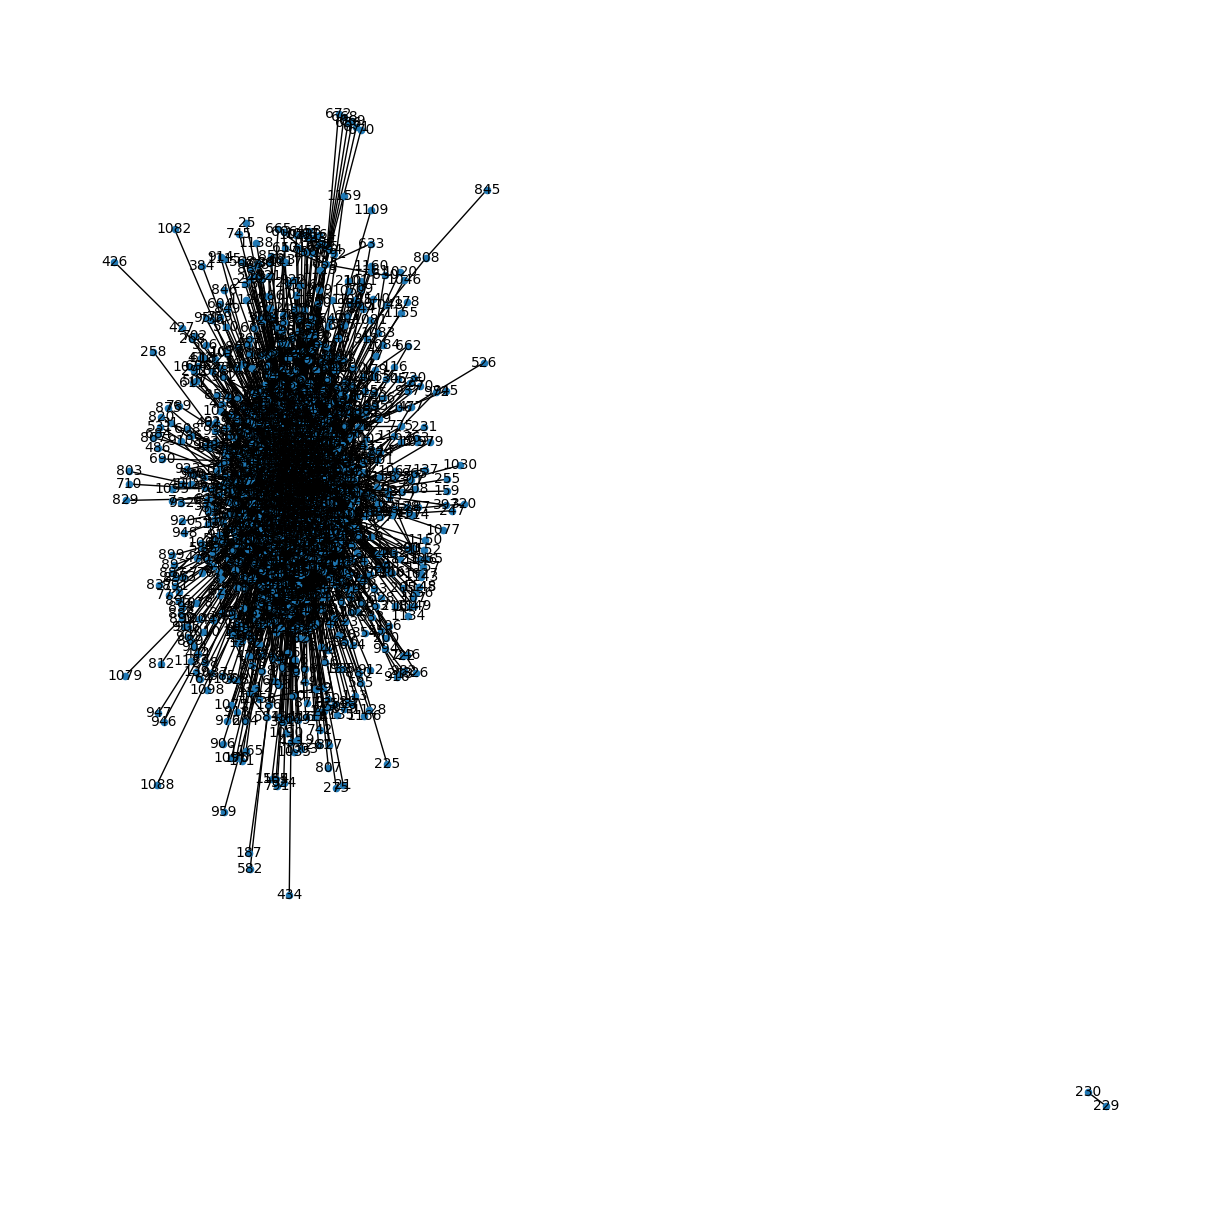

In [19]:
#CODE:
# 1 读取文件并存储信息
data_path = 'p2p_msg_cmt224.csv'
data = pd.read_csv(data_path)
# 2 通过时间和日期进行排序
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])
data.sort_values('datetime', inplace=True)
print(data.head(20))
# 3 获取最小的时间和日期作为起始点，获取28天内的所有数据
start = data['datetime'].min()
end = start + pd.Timedelta(days=28)
data_in_range = data[(data['datetime'] >= start) & (data['datetime'] < end)]
# 4 将这些在28天范围内的数据建立无向图
G = nx.from_pandas_edgelist(data_in_range, 'person_a', 'person_b', create_using=nx.Graph())
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# 5 可视化网络
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=20, font_size=10)
plt.show()

##### Q2. Using the largest connected component of the network constructed in Task 1, Q1. What is the mean, median and the standard deviation of the differences between the maximum degree of separation of each individual and the average distance between the individual and all others?

In [20]:
#CODE:
# 1 计算图的最大连通组件,并建立子图
largest_connected_component = max(nx.connected_components(G), key=len)
lcc_subgraph = G.subgraph(largest_connected_component)
# 2 对于每个节点
# (1) 最大分离度：计算该节点到最远节点的最短路径长度
# (2) 平均距离：计算该节点的平均路径长度：该节点到其他所有节点的平均路径长度
# (3) 计算差值，存到列表
differences = []
for node in lcc_subgraph.nodes():
    # 计算该节点到所有节点的最短路径长度
    all_path_length = nx.single_source_shortest_path_length(lcc_subgraph, node)
    path_length_list = list(all_path_length.values())
    if all_path_length:
        max_sparation = np.max(path_length_list)
        average_distance = np.mean(path_length_list)
        differences.append(np.abs(max_sparation - average_distance))
# 3 计算列表中所有数据的均值、中位数、标准差
mean_difference = np.mean(differences)
median_difference = np.median(differences)
std_difference = np.std(differences)
print(f"The mean of difference: {mean_difference:.2f}")
print(f"The median of difference: {median_difference:.2f}")
print(f"The standard deviation of difference: {std_difference:.2f}")

The mean of difference: 2.24
The median of difference: 2.23
The standard deviation of difference: 0.40


##### Q3. Build another suitable network to represent social connections based on ALL message behaviour in the dataset. In doing so, assume that one or messages from one person to another represents a MUTUAL underlying social connection (i.e., regardless of whether person_a messaged person_b, person_b messaged person_a, or both at some point).Can the social phenomenon, ‘Triadic Closure’, be supported for the common nodes that exist in both the network created from behaviour for the first 28 days (i.e., from Task 1, Q1) and the network built from all message behaviour?

In [21]:
#CODE:
# 假设列名为 'person_a' 和 'person_b'，若不是请根据上面的输出进行修改
# 构建全数据集的网络
G_full = nx.from_pandas_edgelist(data, 'person_a', 'person_b', create_using=nx.Graph())

# 假设G是之前构建的基于首28天的网络
# 找出两个网络共有的节点
common_nodes = set(G.nodes()).intersection(set(G_full.nodes()))

# 对共有节点创建子图
subgraph_28 = G.subgraph(common_nodes)
subgraph_full = G_full.subgraph(common_nodes)

# 计算三元闭包系数
triadic_closure_28 = nx.transitivity(subgraph_28)
triadic_closure_full = nx.transitivity(subgraph_full)

# 输出三元闭包系数
print(f"首28天网络的三元闭包系数: {triadic_closure_28:.2f}")
print(f"完整数据集网络的三元闭包系数: {triadic_closure_full:.2f}")

首28天网络的三元闭包系数: 0.05
完整数据集网络的三元闭包系数: 0.07


##### Q4. What hypothetical, non-existent edges would need to be added to the network representing all message behaviour (i.e., from Task 1, Q3) such that a message could pass along a path from any node to any other? In doing so, aim to minimise the number of edges that would be needed as well as the longest shortest path in the network as a result.

In [22]:
#CODE:
"""
all_cc = list(nx.connected_components(G_full))
# 贪心算法连接所有连通分量试图得到最小直径的图
# 直到只剩一个连通分量也就是整个图全连通后停止
while len(all_cc) > 1:
    best_edges = (-1, -1)
    the_longest_shortest_path = float('inf')
    for i in range(len(all_cc)):
        for j in range(i + 1, len(all_cc)):
            # 建立测试图
            test_graph = nx.Graph(G_full)
            # 连接边来测试
            test_graph.add_edge(next(iter(all_cc[i])), next(iter(all_cc[j])))
            # 计算连接该边后图的最大连通组件的最长最短路径
            lcc = max(nx.connected_components(test_graph), key=len)
            # 建立最大连通组件的子图
            subgraph = test_graph.subgraph(lcc)
            # 求子图直径
            test_longest_shortest_path = nx.diameter(subgraph)
            # 贪心
            if test_longest_shortest_path < the_longest_shortest_path:
                the_longest_shortest_path = test_longest_shortest_path
                best_edges = (i, j)
    # 连接直径最小化的两个连通分量
    i, j = best_edges
    G_full.add_edge(next(iter(all_cc[i])), next(iter(all_cc[j])))
    new_component = all_cc[i].union(all_cc[j])
    all_cc = [c for k, c in enumerate(all_cc) if k not in (i, j)]
    all_cc.append(new_component)
# 计算优化后的网络直径
if nx.is_connected(G_full):
    print("New diameter:", nx.diameter(G_full))
else:
    print("Graph is still not connected.")
"""
components = list(nx.connected_components(G_full))
subgraphs = [G_full.subgraph(c).copy() for c in components]

# 计算每个子图的多个中心性指标
centrality_measures = []
for sg in subgraphs:
    centrality = {}
    centrality['betweenness'] = nx.betweenness_centrality(sg)
    centrality['closeness'] = nx.closeness_centrality(sg)
    centrality['degree_centrality'] = nx.degree_centrality(sg)
    centrality_measures.append(centrality)

# 选择每个连通分量的代表节点
rep_nodes = []
for idx, sg in enumerate(subgraphs):
    # 综合考虑多个中心性指标
    combined_score = {node: centrality_measures[idx]['betweenness'][node] * 0.4 +
                             centrality_measures[idx]['closeness'][node] * 0.3 +
                             centrality_measures[idx]['degree_centrality'][node] * 0.3
                      for node in sg.nodes()}
    # 选择综合得分最高的节点
    best_node = max(combined_score, key=combined_score.get)
    rep_nodes.append(best_node)

# 连接这些代表节点
new_edges = [(rep_nodes[i], rep_nodes[i+1]) for i in range(len(rep_nodes)-1)]
G_full.add_edges_from(new_edges)
print(new_edges)

# 检查新图的连通性和尝试计算新的直径
if nx.is_connected(G_full):
    print("New diameter after connecting components:", nx.diameter(G_full))
else:
    print("Still not fully connected.")

[(105, 229), (229, 1258), (1258, 1192), (1192, 1797), (1797, 1812)]
New diameter after connecting components: 10


### Task 2 of 2 

Using the largest connected component of the network constructed from all data in Task 1, Q2, assume the role of an outsider with complete visibility of the network that now wishes to spread a hypothetical message such that everyone in the component would know the information it contained as quickly as possible. Assume that messages will now spread in sequential timesteps using the following mechanism. If an individual is told the message at timestep 𝑡, the individual will forward the message to all of their direct connections at timestep 𝑡+1. Individuals can therefore be told the message more than once. From this, answer the following questions:

##### Q1. If you could only select 1 individual to tell at timestep 0, what set of nodes could you select from which would result in the message being received by everyone in the fewest timesteps as possible and what would the number of timesteps be?

Node: 400   Closeness Centrality: 0.47
Node: 103   Closeness Centrality: 0.46
Node: 32   Closeness Centrality: 0.46
Node: 638   Closeness Centrality: 0.46
Node: 194   Closeness Centrality: 0.45
Node: 41   Closeness Centrality: 0.44
Node: 9   Closeness Centrality: 0.44
Node: 598   Closeness Centrality: 0.44
Node: 713   Closeness Centrality: 0.44
Node: 105   Closeness Centrality: 0.44


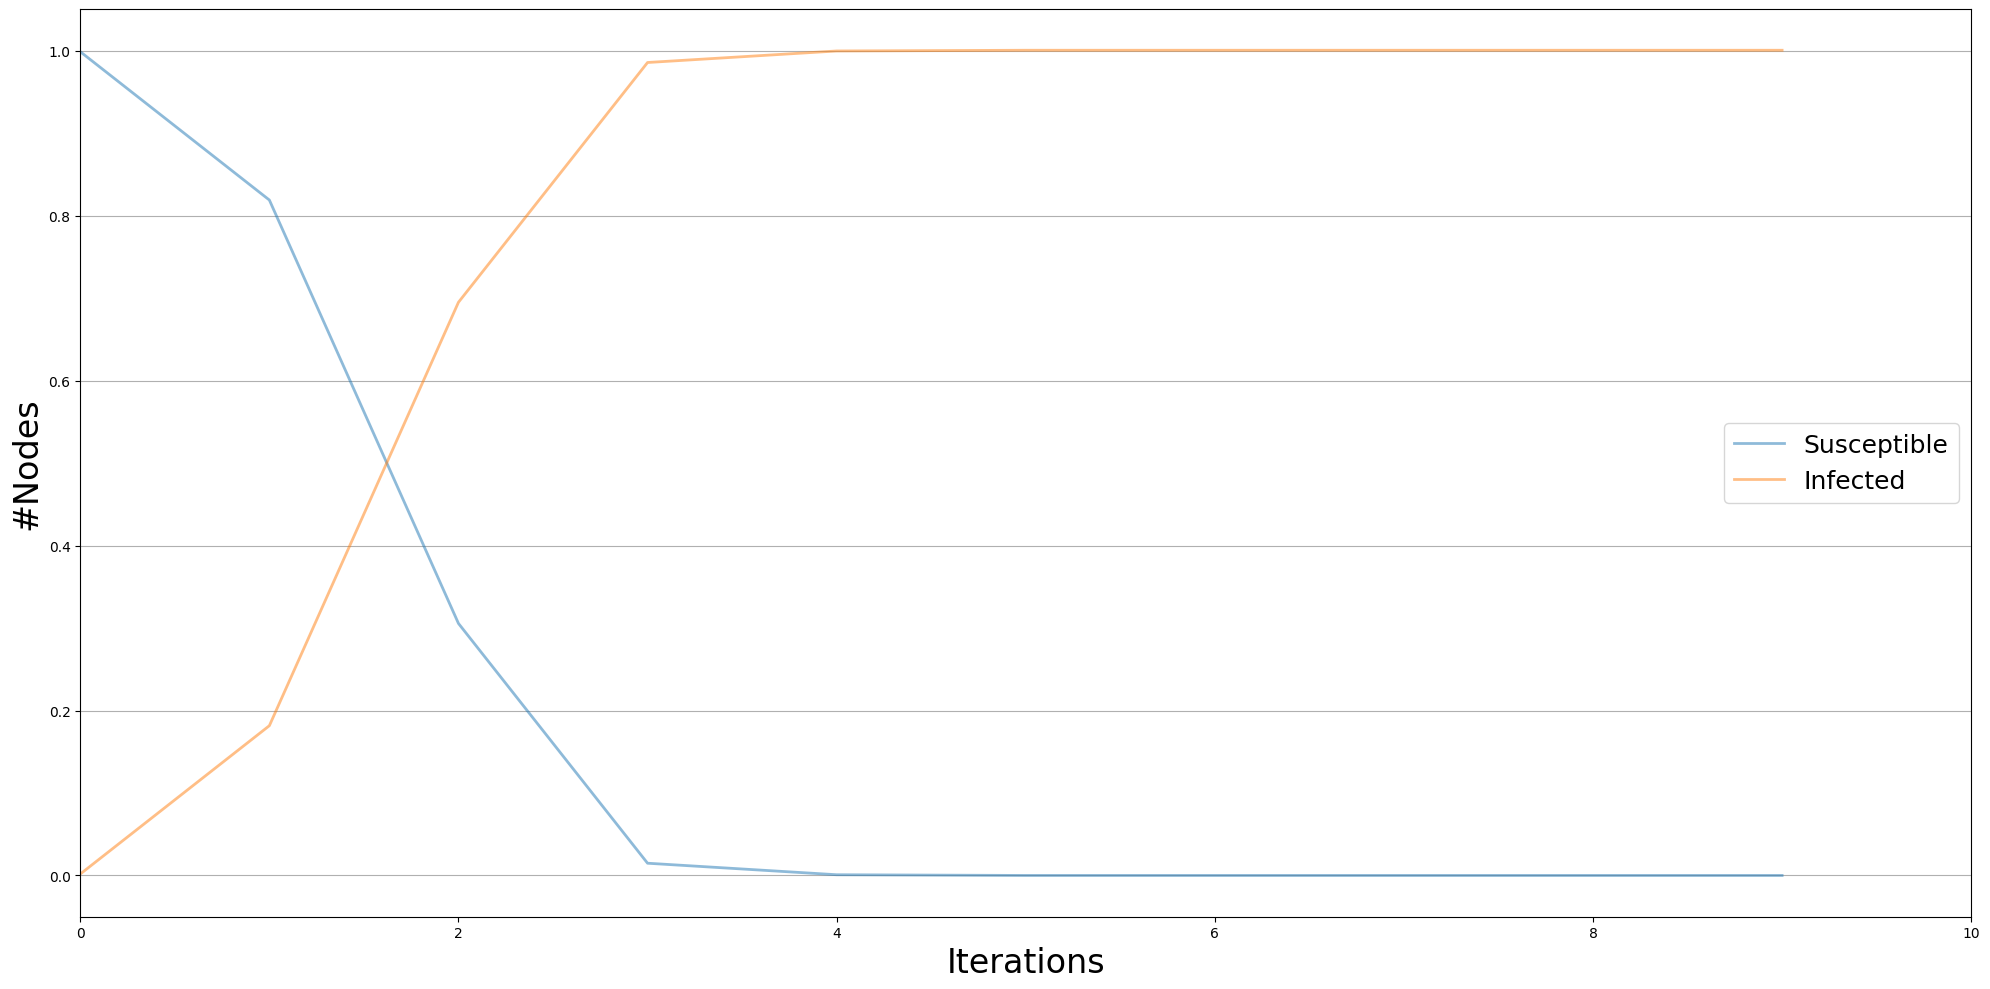

Iteration: 0    Number infected: 2    (0.0017467248908296944)
Iteration: 1    Number infected: 208    (0.18165938864628822)
Iteration: 2    Number infected: 796    (0.6951965065502184)
Iteration: 3    Number infected: 1129    (0.9860262008733625)
Iteration: 4    Number infected: 1145    (1.0)
Threshold met = True after 4 iterations from the initial iteration


In [23]:
#CODE:
# 选出一个节点，使得从该节点传播，最短时间传播到网络中的所有人
# 选初始点指标，紧密中心性，建立紧密中心性从大到小序列
closeness_centrality = sorted(
    [(node[0], node[1]) for node in nx.closeness_centrality(lcc_subgraph).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)
# 输出前五个
for node, centrality in closeness_centrality[:10]:
    print(f"Node: {node}   Closeness Centrality: {centrality:.2f}")

# 函数：传播模型
def runSIModelOnANetwork(G, rate, iterations, initial_infected=None, fraction_infected=None, model_seed=1):
    # 传播模型
    model = ep.SIModel(G, seed=model_seed)

    # 配置模型
    # 创建模型配置项
    model_configuration = mc.Configuration()
    # 设置一个节点将信息告知其连接/邻居的几率
    model_configuration.add_model_parameter('beta', rate) # Probability between 0..1 (0..100%)
    # 对模型执行n次迭代来模拟传播，并存储结果
    if initial_infected is not None:
        model_configuration.add_model_initial_configuration("Infected", initial_infected)
    else:
        model_configuration.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(model_configuration)
    iterations = model.iteration_bunch(iterations)
    return model, iterations

# 函数：评估模型
def evaluateModel(network, model, iterations, threshold):
    
    # 绘制传播曲线
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    viz.plot()

    # 输出传播动态
    results = calculate_iterations_to_reach_threshold(
        trends,
        network.number_of_nodes(),
        threshold,
        True
    )
    print(f"Threshold met = {results[0][0]} after {results[0][1]} iterations from the initial iteration")

# 输出传播动态
def calculate_iterations_to_reach_threshold(trends, number_of_nodes, threshold, verbose=False):
    threshold_as_number_of_nodes = (number_of_nodes*threshold)
    iteration_counts_per_simulation = []
    for simulation in trends:
        number_infected_per_iteration = simulation["trends"]["node_count"][1]
        threshold_met = False
        iteration_count = 0
        for iteration, number_infected in enumerate(number_infected_per_iteration):
            if verbose:
                print(f"Iteration: {iteration}    Number infected: {number_infected}    ({(number_infected / number_of_nodes)})")
            if number_infected < threshold_as_number_of_nodes:
                iteration_count += 1
            else:
                threshold_met = True
                break
        iteration_counts_per_simulation.append((threshold_met, iteration_count))
    return iteration_counts_per_simulation

# 运行
network = lcc_subgraph
information_spreading_rate = 1
number_of_iterations = 10
initial_infected_node = closeness_centrality[0]
eva_threshold = 1.0

model, interations = runSIModelOnANetwork(
    network,
    information_spreading_rate,
    number_of_iterations,
    initial_infected=initial_infected_node
)
evaluateModel(
    network,
    model,
    interations,
    eva_threshold
)

##### Q2. If you had to select any 5 individuals to tell at timestep 0, can the message be received by everyone in fewer timesteps than the single individual selection in Q1? In determining your answer, use one or more appropriate network connectivity measures, rather than an exhaustive search through every combination of nodes in the network.

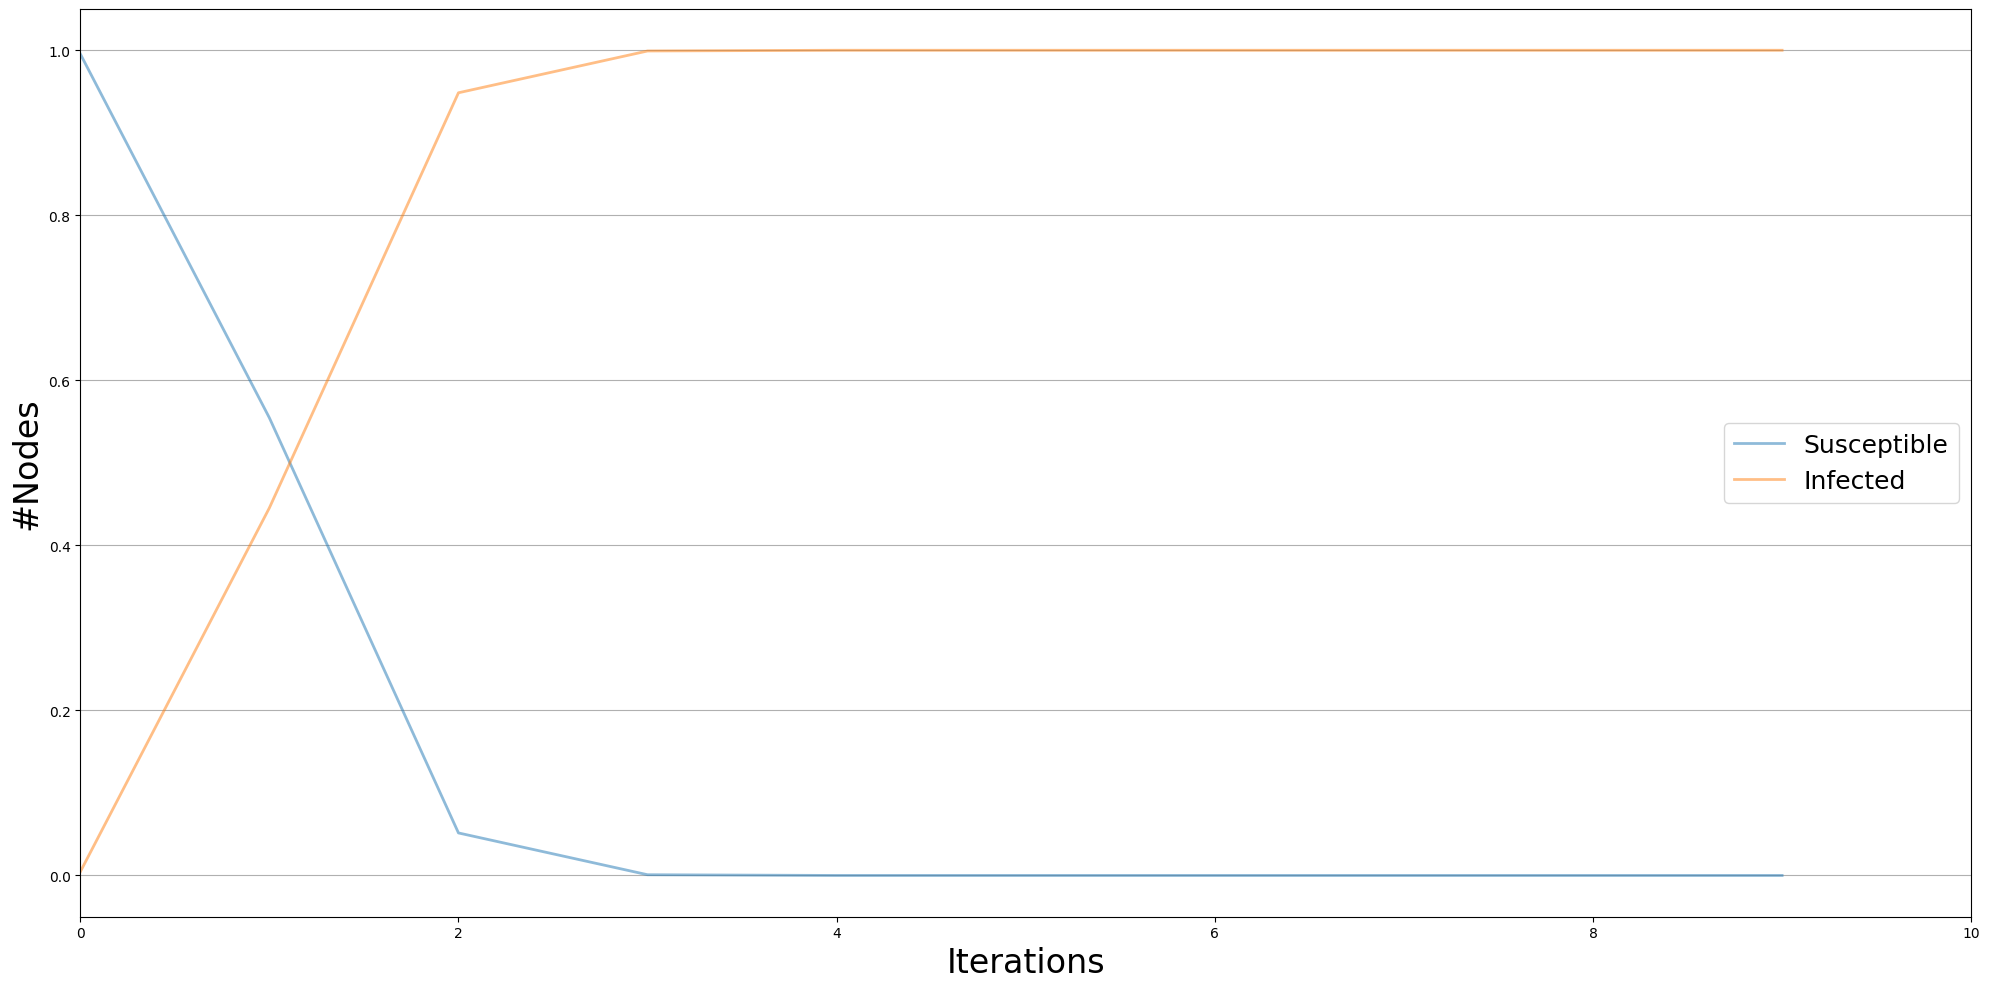

Iteration: 0    Number infected: 5    (0.004366812227074236)
Iteration: 1    Number infected: 510    (0.44541484716157204)
Iteration: 2    Number infected: 1086    (0.948471615720524)
Iteration: 3    Number infected: 1144    (0.9991266375545852)
Iteration: 4    Number infected: 1145    (1.0)
Threshold met = True after 4 iterations from the initial iteration


In [24]:
#CODE:
# 运行
network = lcc_subgraph
information_spreading_rate = 1
number_of_iterations = 10
initial_infected_node = [node[0] for node in closeness_centrality[:5]]
eva_threshold = 1.0

model, interations = runSIModelOnANetwork(
    network,
    information_spreading_rate,
    number_of_iterations,
    initial_infected=initial_infected_node
)
evaluateModel(
    network,
    model,
    interations,
    eva_threshold
)